In [4]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'


Welcome to the Adventure Game!
Type your commands below (e.g., 'go north', 'unlock door', 'find treasure').
You have taken the key.
Turn: 1
A dense forest with towering trees. You hear the sound of rustling leaves.
Exits:
South to Cave
East to Maze




Turn: 2
A twisting maze with no clear direction. It's easy to get lost here.
Exits:
West to Forest

You see:
 * A sturdy door blocking the entrance to the treasure room. You need a key to
unlock it.
 * A chest filled with gold and jewels!


Turn: 3
You unlocked the door!
Your score is now 10 points.
Turn: 4
You found the treasure!
Your score is now 30 points.
Turn: 5
Congratulations! You found the hidden treasure and won the game!
Your final score is 30 points.


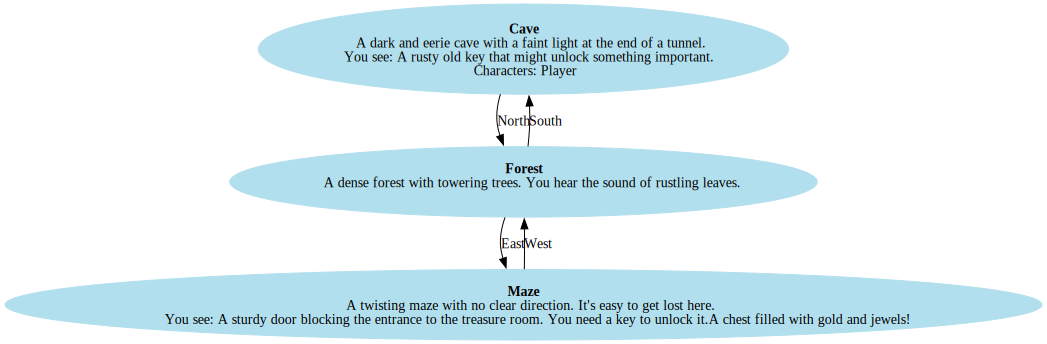

In [21]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

# Defining main game class
class MyAdventureGame(games.Game):
    def __init__(self, start_at: things.Location, player: things.Character, characters=None, custom_actions=None):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)
        self.turn_count = 0  # turn counter
        self.player.set_property("score", 0)  # Initialize score
        self.game_over = False  # tracking game has ended due to too many turns

    def update_turn(self):
        """Update the turn counter and check if the player has taken too many turns."""
        if not self.game_over:  # Only allow the turn to update if the game is not already over
            self.turn_count += 1
            self.parser.ok(f"Turn: {self.turn_count}")

            if self.turn_count > 6:
                # If the player exceeds 6 moves, they lose the game immediately and cannot proceed
                self.parser.fail("A demon appears and kills you for taking too long! You lose.")
                self.player.set_property("score", 0)  # Reset the score to 0
                self.parser.ok(f"Your score is now {self.player.get_property('score')} points.")  # Display 0 points
                self.game_over = True  # game over

    def is_won(self) -> bool:
        """Checks whether the player has won the game."""
        if self.player.get_property("found_treasure") and not self.game_over:
            self.parser.ok("Congratulations! You found the hidden treasure and won the game!")
            self.parser.ok(f"Your final score is {self.player.get_property('score')} points.")
            self.game_over = True
            return True
        return False

# Create new locations with connections
class Cave(things.Location):
    def __init__(self):
        super().__init__(name="Cave", description="A dark and eerie cave with a faint light at the end of a tunnel.")

class Forest(things.Location):
    def __init__(self):
        super().__init__(name="Forest", description="A dense forest with towering trees. You hear the sound of rustling leaves.")

class Maze(things.Location):
    def __init__(self):
        super().__init__(name="Maze", description="A twisting maze with no clear direction. It's easy to get lost here.")

# Create new items and interactions
class Key(things.Item):
    def __init__(self):
        super().__init__(name="key", description="A rusty old key that might unlock something important.")  # Ensure name is lowercase "key"
        self.set_property("can_unlock", True)
        self.set_property("gettable", True)  # Ensure the key can be picked up

class Treasure(things.Item):
    def __init__(self):
        super().__init__(name="treasure", description="A chest filled with gold and jewels!")
        self.set_property("is_treasure", True)

class Door(things.Item):
    def __init__(self):
        super().__init__(name="door", description="A sturdy door blocking the entrance to the treasure room. You need a key to unlock it.")
        self.set_property("locked", True)

# Define action for unlocking the door
class UnlockDoor(actions.Action):
    ACTION_NAME = "unlock"
    ACTION_DESCRIPTION = "Unlock the door with the key."

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command
        self.character = self.game.player
        self.door = self.parser.match_item("door", self.parser.get_items_in_scope(self.character))
        self.key = self.parser.match_item("key", self.parser.get_items_in_scope(self.character))  # Match lowercase "key"

    def check_preconditions(self) -> bool:
        if self.game.game_over:  # Do not allow unlocking if the game is over
            return False
        if not self.door or not self.key or not self.key.get_property("can_unlock"):
            self.parser.fail("You need a key to unlock the door.")
            return False
        return True

    def apply_effects(self):
        self.door.set_property("locked", False)
        self.parser.ok("You unlocked the door!")
        self.character.set_property("score", self.character.get_property("score") + 10)  # Award 10 points for unlocking the door
        self.parser.ok(f"Your score is now {self.character.get_property('score')} points.")  # Display the score

# Define action for taking the key
class TakeKey(actions.Action):
    ACTION_NAME = "take"
    ACTION_DESCRIPTION = "Take the key."

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command
        self.character = self.game.player
        self.key = self.parser.match_item("key", self.parser.get_items_in_scope(self.character))  # Match lowercase "key"

    def check_preconditions(self) -> bool:
        if self.game.game_over:  # Do not allow taking the key if the game is over
            return False
        if not self.key:
            self.parser.fail("There is no key here.")
            return False
        return True

    def apply_effects(self):
        self.character.set_property("has_key", True)  # Player now has the key
        self.character.add_to_inventory(self.key)
        self.parser.ok("You have taken the key.")

# Define action for finding the treasure
class FindTreasure(actions.Action):
    ACTION_NAME = "find"
    ACTION_DESCRIPTION = "Search for the hidden treasure."

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command
        self.character = self.game.player
        self.treasure = self.parser.match_item("treasure", self.parser.get_items_in_scope(self.character))  # Match treasure

    def check_preconditions(self) -> bool:
        if self.game.game_over:  # Do not allow finding treasure if the game is over
            return False
        if not self.treasure:
            self.parser.fail("There is no treasure here.")
            return False
        if not self.character.get_property("has_key"):
            self.parser.fail("You need the key to unlock the treasure chest.")
            return False
        return True

    def apply_effects(self):
        self.character.set_property("found_treasure", True)
        self.parser.ok("You found the treasure!")
        self.character.set_property("score", self.character.get_property("score") + 20)  # Award 20 points for finding the treasure
        self.parser.ok(f"Your score is now {self.character.get_property('score')} points.")  # Display the score

# Sample Game Setup
def setup_game():
    # Create locations
    cave = Cave()
    forest = Forest()
    maze = Maze()

    # Connect locations
    cave.connections["north"] = forest
    forest.connections["south"] = cave
    forest.connections["east"] = maze
    maze.connections["west"] = forest

    # Create items and characters
    key = Key()
    treasure = Treasure()
    door = Door()

    # Create player and starting location
    player = things.Character(name="Player", description="A brave adventurer", persona="Heroic")
    player.set_property("has_key", False)  # Initial condition: Player does not have the key
    player.set_property("found_treasure", False)  # Initial condition: Player has not found the treasure
    player.set_property("score", 0)  # Initial condition: Player starts with 0 points
    game = MyAdventureGame(start_at=cave, player=player)

    # Add items to locations
    cave.add_item(key)   # Key is in the cave
    maze.add_item(door)  # Door is in the maze
    maze.add_item(treasure)  # Treasure is in the maze behind the door

    # Create a parser for the game and add custom actions
    game_parser = parsing.Parser(game)
    game_parser.add_action(TakeKey)  # Add action to take the key
    game_parser.add_action(UnlockDoor)  # Add action to unlock the door
    game_parser.add_action(FindTreasure)  # Add action to find the treasure

    return game_parser

# Command loop for running the game
def run_game():
    game_parser = setup_game()
    
    print("Welcome to the Adventure Game!")
    print("Type your commands below (e.g., 'go north', 'unlock door', 'find treasure').")
    
    while True:
        command = input("\n> ")
        
        # If the player types 'quit', end the game
        if command.lower() == "quit":
            print("Thanks for playing! Goodbye.")
            break
        
        # Parse the command and act on it
        game_parser.parse_command(command)
        game_parser.game.update_turn()  # Update turn after each command

        # Check if the game is over
        if game_parser.game.game_over:
            break
        
        # Check if the player won the game
        if game_parser.game.is_won():
            break
    

# Run the game
run_game()
game_parser1 = setup_game()
from text_adventure_games.viz import Visualizer
viz = Visualizer(game_parser1.game)
graph = viz.visualize()
graph

